# Manuscript plots

This notebook creates the figures in Parviainen (2015, submitted to MNRAS). The figures show the calculation of quadratic limb darkening coefficients for three broadband filters (for simplicity defined using boxcar filters) and 19 narrow-band filters.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sb
from matplotlib.patches import Ellipse
from scipy.stats import chi2

from ldtk import LDPSetCreator, BoxcarFilter, TabulatedFilter

AAOCW, AAPGW = 3.465, 7.087
rc(['xtick','ytick','axes'], labelsize=8)

def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]
    
def bve(data, volume=0.5):
    vals, vecs = eigsorted(cov(data, rowvar=0))
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * np.sqrt(chi2.ppf(volume,2)) * np.sqrt(vals)
    return width, height, theta

## Broadband filters

In [3]:
filters = [BoxcarFilter('a',450,550),
           BoxcarFilter('b',650,750),
           BoxcarFilter('c',850,950)]

In [4]:
sc = LDPSetCreator(teff=(6400,50), logg=(4.5,0.1), z=(0.25,0.05), filters=filters)

In [5]:
ps = sc.create_profiles(nsamples=2000)
ps.resample_linear_z(100)
qm,qe = ps.coeffs_qd(do_mc=True)

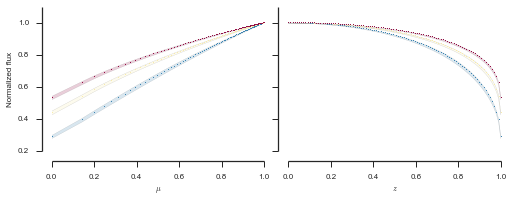

In [6]:
ec = 3
cp = cm.Spectral_r(linspace(0.1,1.0,3))

with sb.axes_style('ticks'):
    fig,ax = subplots(1,2,figsize=(AAPGW,0.8*AAOCW), sharey=True)
    for i in range(ps._nfilters):
        c = sb.desaturate(cp[i],0.85)
        ax[0].fill_between(ps._mu, ps._mean[i]-ec*ps._std[i], ps._mean[i]+ec*ps._std[i], facecolor=c, alpha=0.2)
        ax[0].plot(ps._mu,      ps._mean[i], ',', c=c);
        #ax[0].plot(ps._mu_orig, ps._mean_orig[i], '.', c=c);
        ax[1].fill_between(ps._z, ps._mean[i]-ec*ps._std[i], ps._mean[i]+ec*ps._std[i], facecolor=c, alpha=0.2)
        ax[1].plot(ps._z,       ps._mean[i], ',', c=c);
        #ax[1].plot(ps._z_orig/ps._limb_z,  ps._mean_orig[i], '.', c=c);
    setp(ax[0], xlabel='$\mu$', ylabel='Normalized flux', xlim=(0,1))
    setp(ax[1], xlabel='$z$', xlim=(0,1))
    sb.despine(fig, offset=10)
    setp(ax[1].get_yticklabels(), visible=False)
    fig.tight_layout()
    fig.subplots_adjust(left=0.1, right=0.98, bottom=0.25, top=0.97)    
    fig.savefig('plots/example_profiles.pdf')
    fig.savefig('plots/example_profiles.png', dpi=150)

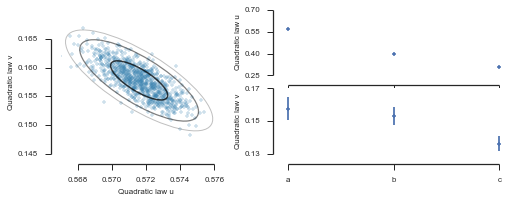

In [7]:
chains = array(ps._samples['qd'])
est_u = percentile(chains[:,:,0], [50,0.5,99.5], 1)
est_v = percentile(chains[:,:,1], [50,0.5,99.5], 1)

with sb.axes_style('ticks'):
    fig = figure(figsize=(AAPGW,0.8*AAOCW))
    gs = GridSpec(2,3, width_ratios=[2,1,1])
    ad = subplot(gs[:,0])
    au = subplot(gs[0,1:])
    av = subplot(gs[1,1:])

    ch = chains[0]
    m = mean(ch, 0)
    c = sb.desaturate(cp[0],0.85)
    ad.plot(ch[::20,0],ch[::20,1], '.', c=c, alpha=0.25)
    ad.add_patch(Ellipse(m, *bve(ch[::25,:], 0.50), fill=False, lw=1.50, ec='k', zorder=100, alpha=0.75))
    ad.add_patch(Ellipse(m, *bve(ch[::25,:], 0.95), fill=False, lw=1.25, ec='k', zorder=100, alpha=0.50))
    ad.add_patch(Ellipse(m, *bve(ch[::25,:], 0.99), fill=False, lw=1.00, ec='k', zorder=100, alpha=0.25))
    
    au.errorbar((1,2,3), est_u[0], abs(est_u[0]-est_u[1:]).mean(0), fmt='.')
    av.errorbar((1,2,3), est_v[0], abs(est_v[0]-est_v[1:]).mean(0), fmt='.')
    
    setp(ad, xlabel='Quadratic law u', ylabel='Quadratic law v', xlim=(0.567,0.577))
    setp([au,av], xlim=(0.95,3.05), xticks=[1,2,3], xticklabels='a b c'.split())
    setp(au, ylabel='Quadratic law u', ylim=(0.30,0.64), yticks=[0.25,0.40,0.55,0.70])
    setp(av, ylabel='Quadratic law v', ylim=(0.13, 0.17), yticks=[0.13,0.15,0.17])
    sb.despine(fig, offset=10, trim=True)
    setp(au.get_xticklabels(), visible=False)
    fig.subplots_adjust(left=0.12, right=0.99, bottom=0.25, top=0.97, wspace=0.45)
    fig.savefig('plots/example_coefficients.pdf')
    fig.savefig('plots/example_coefficients.png', dpi=150)

## Narrow band filters

In [8]:
f_edges   = arange(500,800,15)
f_centres = 0.5*(f_edges[1:] + f_edges[:-1])
filters   = [BoxcarFilter('t', a, b) for a,b in zip(f_edges[:-1], f_edges[1:])]

In [9]:
sc = LDPSetCreator(teff=(6400,50), logg=(4.5,0.2), z=(0.25,0.05), filters=filters)
ps = sc.create_profiles(nsamples=5000)
qc,qe = ps.coeffs_qd(do_mc=True, n_mc_samples=50000)

In [10]:
sc_wide = LDPSetCreator(teff=(6400,50), logg=(4.5,0.2), z=(0.25,0.05), filters=[BoxcarFilter('wide',500,800)])
ps_wide = sc_wide.create_profiles(nsamples=5000)
qc_wide,qe_wide = ps_wide.coeffs_qd(do_mc=True, n_mc_samples=50000)

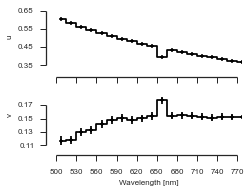

In [15]:
with sb.axes_style('ticks'):
    fig,axs = subplots(2,1,figsize=(AAOCW,0.75*AAOCW), sharex=False)
    for i in range(2):
        axs[i].plot(f_centres, qc[:,i], drawstyle='steps-mid', c='k')
        axs[i].errorbar(f_centres, qc[:,i], qe[:,i], fmt='k.')
    setp(axs, xlim=(500,775), xticks=linspace(500,800,11))
    setp(axs[0], ylabel='u', ylim=(0.34,0.67), yticks=[0.35,0.45,0.55,0.65])
    setp(axs[1], ylabel='v', xlabel='Wavelength [nm]',
         yticks=[0.11,0.13,0.15,0.17], ylim=(0.11,0.20))
    sb.despine(fig, offset=10, trim=True)
    setp(axs[0].get_xticklabels(), visible=False)
    fig.tight_layout()
    fig.subplots_adjust(left=0.21, right=0.95, bottom=0.25, top=0.99)
    fig.savefig('plots/qd_coeffs_narrow.pdf')
    fig.savefig('plots/qd_coeffs_narrow.png', dpi=150)